# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [0]:
import tensorflow as tf
import csv
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import keras
from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import Sequence, np_utils
from keras.backend import epsilon
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Using TensorFlow backend.


### Change directory

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
project_path = "drive/My Drive/R9_External"

### Load the training data from train.csv file

In [0]:
train = pd.read_csv("drive/My Drive/R9_External/train_labels.csv")

### Print the shape of the train dataset

In [83]:
train.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128

In [85]:
train.head(3)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290


### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
fileNames = train["filename"]
paths = []
# fileNames.count()
for path in fileNames:
  paths.append(project_path + "/images/" + path )

In [29]:
paths[172]

'drive/My Drive/R9_External/images/raccoon-152.jpg'

In [87]:
# convert to matrix
coords = np.zeros((len(paths), 4))
coords.shape

(173, 4)

In [0]:
for i in range(0, len(paths)):
    image_width=train.loc[i,'width'].astype('int32')
    image_height=train.loc[i,'height'].astype('int32')
    x0=train.loc[i,'xmin'].astype('int32')
    y0=train.loc[i,'ymin'].astype('int32')
    x1=train.loc[i,'xmax'].astype('int32')
    y1=train.loc[i,'ymax'].astype('int32')
    # Normalize bounding box by image size
    coords[i, 0] = x0 * IMAGE_SIZE / image_width
    coords[i, 1] = y0 * IMAGE_SIZE / image_height
    coords[i, 2] = (x1 - x0) * IMAGE_SIZE / image_width
    coords[i, 3] = (y1 - y0) * IMAGE_SIZE / image_height

In [89]:
print(coords[0,1])
print(coords[172,2])

39.58762886597938
84.71272727272728


### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i in range(0,len(paths)):
    img = Image.open(paths[i]) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
#Importing MobileNet Model
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=1) 
#freezing layers
for layer in model.layers:
    layer.trainable = False
#Adding Layers
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
x = Reshape((4,))(x) #Predictions of coordinates

model = Model(inputs=model.input, outputs=x)

In [61]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [94]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU])
model.fit(x=batch_images, y=coords, epochs=30, batch_size=32, verbose=1)

Epoch 1/30
173/173 [==============================] - 6s 37ms/step - loss: 2810.5635 - IoU: 0.0839
Epoch 2/30
173/173 [==============================] - 5s 28ms/step - loss: 642.0292 - IoU: 0.4388
Epoch 3/30
173/173 [==============================] - 5s 29ms/step - loss: 639.6063 - IoU: 0.5382
Epoch 4/30
173/173 [==============================] - 5s 28ms/step - loss: 573.1731 - IoU: 0.5393
Epoch 5/30
173/173 [==============================] - 5s 27ms/step - loss: 342.7075 - IoU: 0.5912
Epoch 6/30
173/173 [==============================] - 5s 28ms/step - loss: 277.0053 - IoU: 0.5862
Epoch 7/30
173/173 [==============================] - 5s 28ms/step - loss: 242.1968 - IoU: 0.6089
Epoch 8/30
173/173 [==============================] - 5s 28ms/step - loss: 186.0173 - IoU: 0.6674
Epoch 9/30
173/173 [==============================] - 5s 28ms/step - loss: 161.8643 - IoU: 0.7110
Epoch 10/30
173/173 [==============================] - 5s 28ms/step - loss: 139.4902 - IoU: 0.7295
Epoch 11/30
173/17

### Pick a test image from the given data

In [95]:
img=Image.open(paths[96])
img.size

(268, 188)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
img_inp = img.resize((128, 128))
img_inp = preprocess_input(np.array(img_inp, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [97]:
region = model.predict(x=np.array([img_inp]))[0]
region

array([49.762985, 37.397373, 54.621014, 76.25856 ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

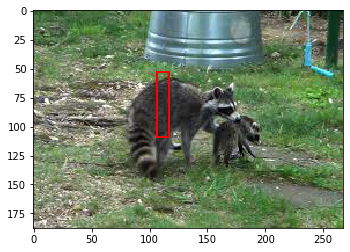

In [98]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()